In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") # веса

In [3]:
thr = 0.5 # порог уверенности (confidence threshold)

# иземенение размера изображения
width =368
height = 368

In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [5]:
img = cv.imread("pose.png")
img.shape

(4809, 3200, 3)

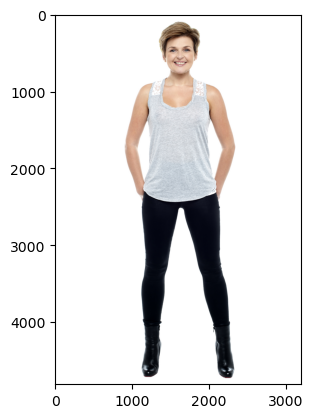

In [6]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) #BGR

In [7]:
def pose_estimation(frame):
    
    #  ширина и высота исходного изображения.
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # преобразование в тензор batch_size × channels × height × width
    '''
    frame - Входное изображение 
    1.0 - Масштабный коэффициент 
    (width, height) - Размер, к которому будет приведено изображение перед подачей в сеть.
    (127.5, 127.5, 127.5) - Средние значения по каждому каналу (B, G, R), которые будут вычитаться из изображения.
    Это нормализация.
    swapRB=True - Меняет местами каналы R и B.
    '''
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (width, height), (127.5, 127.5, 127.5), swapRB = True, crop = False)) # 255 / 2
    out = net.forward() # выход нейросети (тензор с тепловыми картами для каждой части тела)
    #print(out.shape)
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) <= out.shape[1]) # количество частей тела не  должно превышать число каналов в выходе.
    
    '''
    Для каждой части тела:
        1. Извлекается тепловая карта.
        2. Находится точка с максимальной уверенностью.
        3. Координаты масштабируются под размер исходного изображения.
        4. Если уверенность выше порога, точка сохраняется.
    '''

    points = []
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        points.append((int(x), int(y)) if conf > thr else None)
        
    '''
    Для каждой пары частей тела:
        Проверяется, найдены ли обе точки.
        Если да — рисуется линия между ними и кружки на самих точках.
    '''
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 10)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    return frame

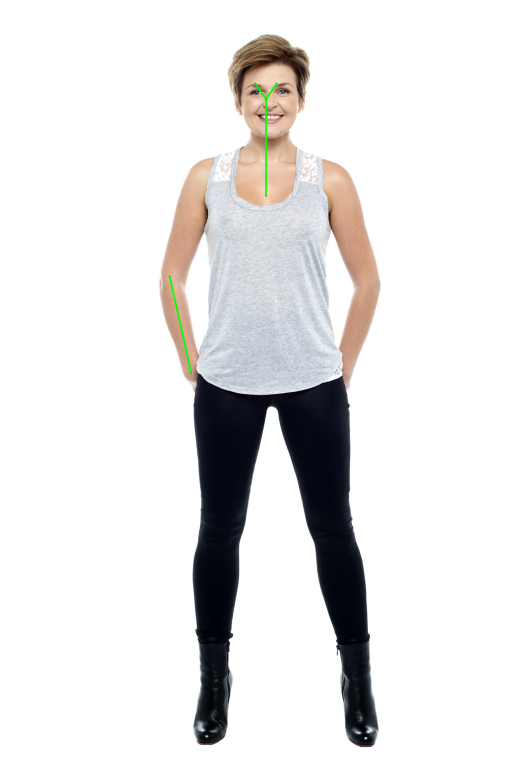

In [8]:
estimated_image = pose_estimation(img)

fig, ax = plt.subplots(dpi=200)
ax.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))
ax.axis('off')
plt.show()



In [ ]:
# из предзагруженных видео


cap = cv.VideoCapture("yoga_poses2.mp4")
#cap = cv.VideoCapture(0)


if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("CannotOpenVideo")
    
while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (width, height), (127.5, 127.5, 127.5), swapRB = True, crop = False)) # 255 / 2
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) <= out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 10)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    import cv2 as cv

    cv.namedWindow("yoga poses estimation", cv.WINDOW_NORMAL)  # позволяет изменять размер окна
    cv.resizeWindow("yoga poses estimation", 900, 600)  # задаёт размер окна

    cv.imshow("yoga poses estimation", frame)
    